In [1]:
# Copyright (c) 2015-2016, the authors (see AUTHORS.txt).
# Licensed under the BSD 3-clause license (see LICENSE.txt)
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook

import unittest
import deepgp
import GPy
import os
import h5py
import tables

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs
from sklearn.decomposition import PCA
import scipy
base_path = os.path.dirname("__file__")

<IPython.core.display.Javascript object>


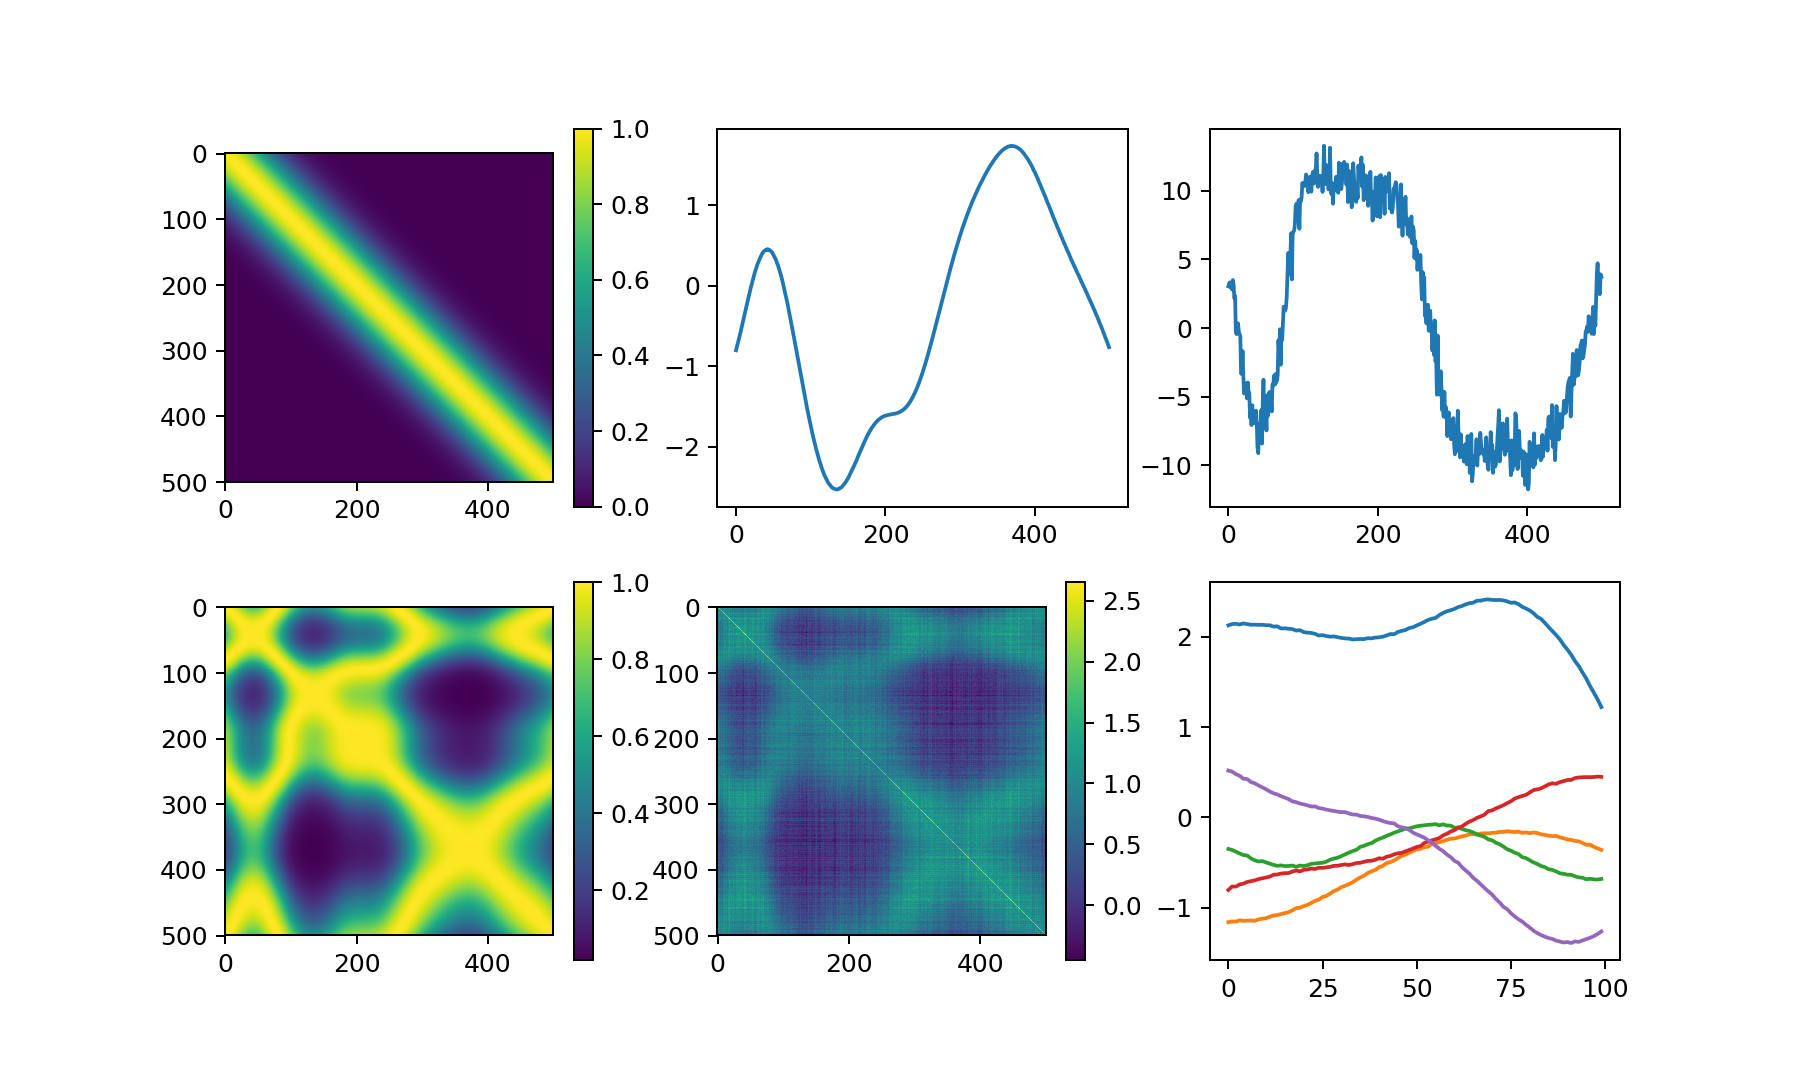

Number of data points N=500
Number of features D=200
Number of latent dimensions K=1


In [2]:
data = scipy.io.loadmat('syn_test.mat')
x_true = data['x_true']
xgrid = data['xgrid']
z_true = data['z_true']
zgrid = data['zgrid']
tgrid = data['tgrid']
Kz_true = data['Kz_true']
Kprior_true = data['Kprior_true']

N = x_true.shape[0]
D = x_true.shape[1]
K = z_true.shape[1]

pca = PCA(n_components=K)
z_init = pca.fit_transform(x_true)

plt.subplots(2,3,figsize=(10,6))
plt.subplot(2,3,1)
plt.imshow(Kprior_true)
plt.colorbar()
plt.subplot(2,3,2)
plt.plot(z_true)

plt.subplot(2,3,4)
plt.imshow(Kz_true)
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,6)
plt.plot(xgrid[:,:5])
plt.subplot(2,3,3)
plt.plot(z_init)

print("Number of data points N={}".format(N))
print("Number of features D={}".format(D))
print("Number of latent dimensions K={}".format(K))

In [3]:
def const(x):
    x = tf.constant(x,dtype=tf.float32)
    return x

prior_l=2
prior_sig_f=1
l=0.5
sig_f=1
H1 = 50
m = deepgp.DeepGP([x_true.shape[1],H1,K,tgrid.shape[1]],Y=x_true,X=tgrid,
                  kernels=[GPy.kern.RBF(H1,ARD=True),GPy.kern.RBF(K,ARD=True), 
                           GPy.kern.RBF(tgrid.shape[1],variance=prior_sig_f,lengthscale=prior_l,ARD=True)], 
                  num_inducing=50, inits='PCA', back_constraint=False)
# m.layer_1.rbf.variance.fix()
# m.layer_1.rbf.lengthscale.fix()
# m.layer_1.Gaussian_noise.variance = 0.00001
# m.layer_1.Gaussian_noise.variance.fix()
m.inits
print(m)
m.optimize()
print(m)


In util:  PCA
In util:  PCA

Name : deepgp
Objective : 1479653.6425125108
Number of Parameters : 53808
Number of Optimization Parameters : 53808
Updates : True
Parameters:
  deepgp.                           |      value  |  constraints  |  priors
  obslayer.inducing_inputs          |   (50, 50)  |               |        
  obslayer.rbf.variance             |        1.0  |      +ve      |        
  obslayer.rbf.lengthscale          |      (50,)  |      +ve      |        
  obslayer.Gaussian_noise.variance  |        1.0  |      +ve      |        
  obslayer.Kuu_var                  |      (50,)  |      +ve      |        
  obslayer.latent_space.mean        |  (500, 50)  |               |        
  obslayer.latent_space.variance    |  (500, 50)  |      +ve      |        
  layer_1.inducing_inputs           |    (50, 1)  |               |        
  layer_1.rbf.variance              |        1.0  |      +ve      |        
  layer_1.rbf.lengthscale           |        1.0  |      +ve      | 

In [6]:
def plot_kern(model,layer1_flag=True):
    if not layer1_flag:
        Kxx = model.kern.K(model.X.mean, model.X.mean)
    else:
        Kxx = model.kern.K(model.X, model.X)
    plt.subplots(2,2,figsize=(6,4))
    plt.subplot(2,2,1)
    plt.imshow(Kxx)
    plt.colorbar()

    Kuu = model.kern.K(model.Z, model.Z)+np.diag(model.Kuu_var)
    plt.subplot(2,2,2)
    plt.imshow(Kuu)
    plt.colorbar()

    if not layer1_flag:
        Kxu = model.kern.K(model.X.mean, model.Z)
    else:
        Kxu = model.kern.K(model.X, model.Z)
    plt.subplot(2,2,3)
    plt.imshow(Kxu)
    plt.colorbar()

    K1 = Kxu @ np.linalg.inv(Kuu) @ Kxu.T
    plt.subplot(2,2,4)
    plt.imshow(K1)
    plt.colorbar()
    return K1


Name : layer_2
Objective : 1374.571400691366
Number of Parameters : 103
Number of Optimization Parameters : 103
Updates : True
Parameters:
  layer_2.                 |              value  |  constraints  |  priors
  inducing_inputs          |            (50, 1)  |               |        
  rbf.variance             |  3.22158304632e-05  |      +ve      |        
  rbf.lengthscale          |      3.74030024585  |      +ve      |        
  Gaussian_noise.variance  |      14.1101912416  |      +ve      |        
  Kuu_var                  |              (50,)  |      +ve      |        
  rbf.         |              value  |  constraints  |  priors
  variance     |  3.22158304632e-05  |      +ve      |        
  lengthscale  |      3.74030024585  |      +ve      |        
(50, 1)


<IPython.core.display.Javascript object>


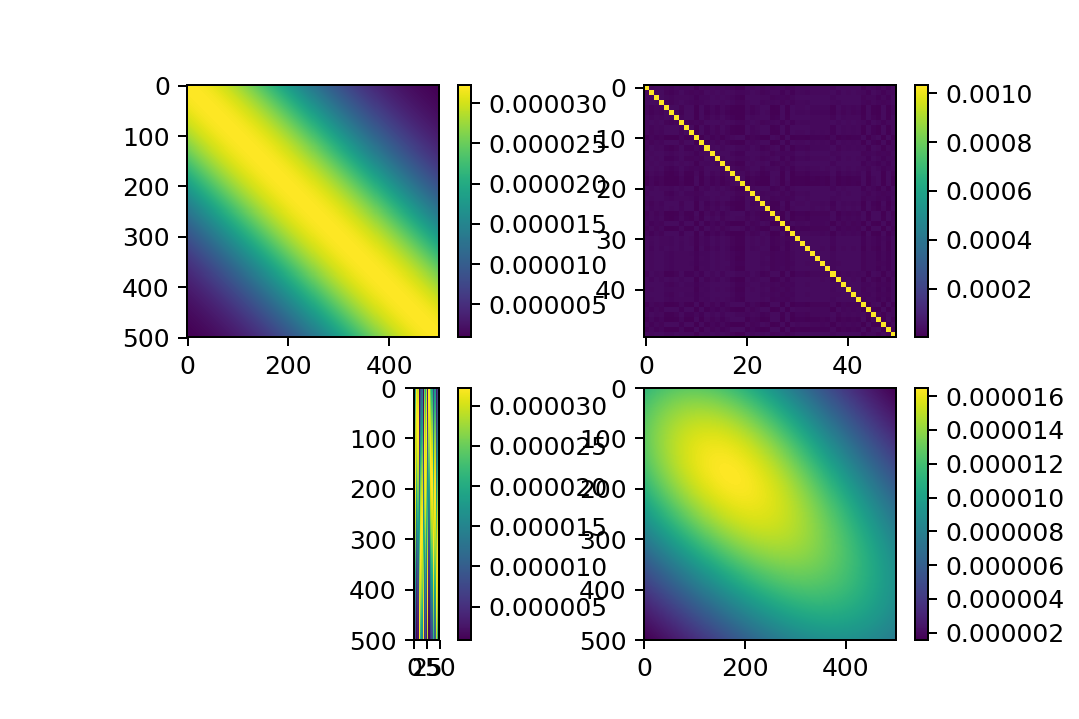

In [7]:
print(m.layer_2)
print(m.layer_2.kern)
print(m.layer_2.inducing_inputs.shape)
K2 = plot_kern(m.layer_2)


Name : layer_1
Objective : -12652.614596024421
Number of Parameters : 1103
Number of Optimization Parameters : 1103
Updates : True
Parameters:
  layer_1.                 |              value  |  constraints  |  priors
  inducing_inputs          |            (50, 1)  |               |        
  rbf.variance             |  9.09844042049e-24  |      +ve      |        
  rbf.lengthscale          |      68.0058017639  |      +ve      |        
  Gaussian_noise.variance  |    0.0237492086429  |      +ve      |        
  Kuu_var                  |              (50,)  |      +ve      |        
  latent_space.mean        |           (500, 1)  |               |        
  latent_space.variance    |           (500, 1)  |      +ve      |        
  rbf.         |              value  |  constraints  |  priors
  variance     |  9.09844042049e-24  |      +ve      |        
  lengthscale  |      68.0058017639  |      +ve      |        
(50, 1)


<IPython.core.display.Javascript object>


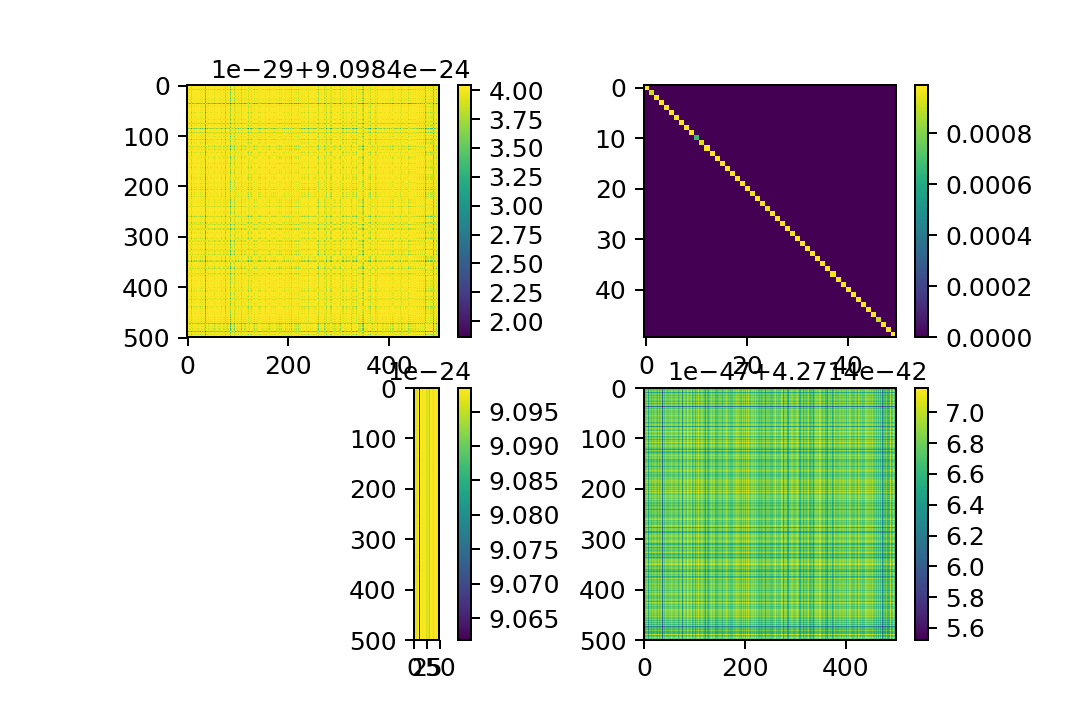

In [10]:
print(m.layer_1)
print(m.layer_1.kern)
print(m.layer_1.inducing_inputs.shape)
K1 = plot_kern(m.layer_1,layer1_flag=False)


Name : obslayer
Objective : 189367.6451799763
Number of Parameters : 52602
Number of Optimization Parameters : 52602
Updates : True
Parameters:
  obslayer.                |              value  |  constraints  |  priors
  inducing_inputs          |           (50, 50)  |               |        
  rbf.variance             |  2.96812006889e-87  |      +ve      |        
  rbf.lengthscale          |              (50,)  |      +ve      |        
  Gaussian_noise.variance  |      2.06252739827  |      +ve      |        
  Kuu_var                  |              (50,)  |      +ve      |        
  latent_space.mean        |          (500, 50)  |               |        
  latent_space.variance    |          (500, 50)  |      +ve      |        
  rbf.         |              value  |  constraints  |  priors
  variance     |  2.96812006889e-87  |      +ve      |        
  lengthscale  |              (50,)  |      +ve      |        
(50, 50)


<IPython.core.display.Javascript object>


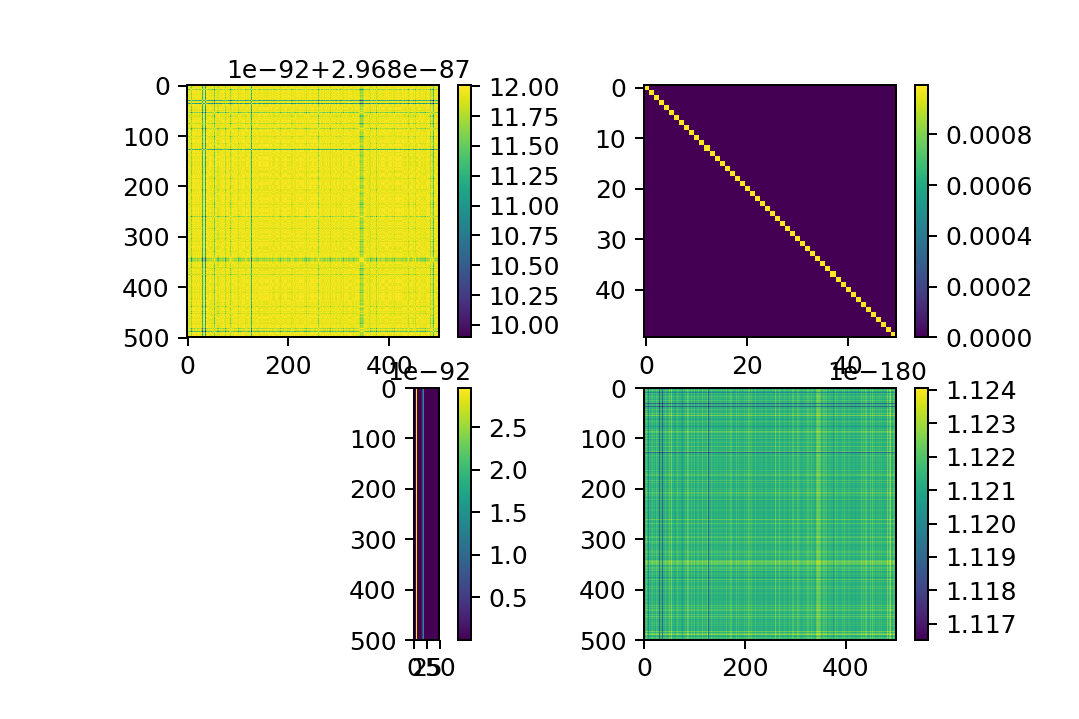

In [11]:
print(m.obslayer)
print(m.obslayer.kern)
print(m.obslayer.inducing_inputs.shape)

Ko = plot_kern(m.obslayer,layer1_flag=False)

<IPython.core.display.Javascript object>


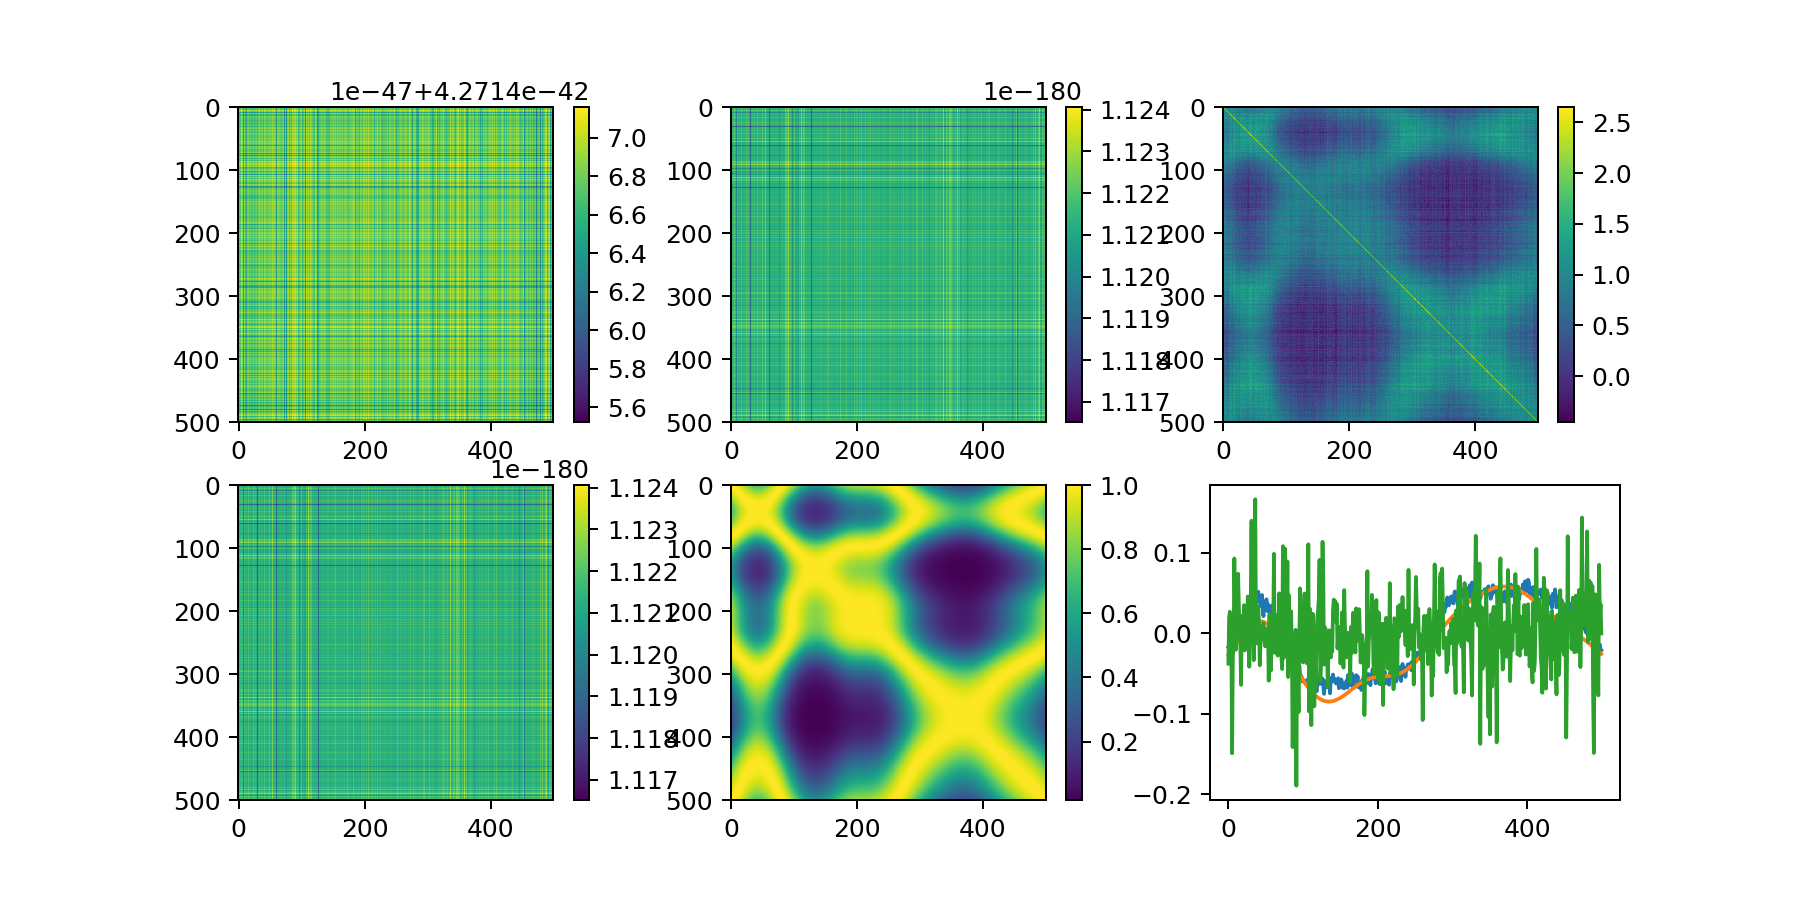

In [16]:
def match_z(x,z):
    cp = np.corrcoef(x.T,z.T)[0,1]
    cn = np.corrcoef(-x.T,z.T)[0,1]
    if cp<cn:
        return -x
    else:
        return x
    
plt.subplots(2,3,figsize=(10,5))
plt.subplot(2,3,1)
plt.imshow(K1)
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(K2)
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(Ko)
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(Kz_true)
plt.colorbar()
plt.subplot(2,3,6)
plt.plot(match_z(z_init/np.linalg.norm(z_init),z_true/np.linalg.norm(z_true)))
plt.plot(z_true/np.linalg.norm(z_true))
# plt.plot(match_z(m.obslayer.X.mean/np.linalg.norm(m.obslayer.X.mean),z_true/np.linalg.norm(z_true)))
plt.plot(match_z(m.layer_1.X.mean/np.linalg.norm(m.layer_1.X.mean),z_true/np.linalg.norm(z_true)))

